In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)
data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

data_all.shape

In [126]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features
import pandas as pd
import pickle
import os
import numpy as np
from copy import deepcopy


def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>30:
        return [],[],[],[],[],[],[]
    index2 = np.isnan(ecg_rr)
    ecg_rr[np.isnan(ecg_rr)] = 0
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.mean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    weights = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         ppg_qual[index2] = -.1
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<30:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        index = np.isnan(ppg_qual)
        ppg_qual[index] = -.5
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        for k in range(4):
            tmp[np.isnan(tmp[:,k]),k] = np.nanmean(tmp[tmp[:,k]>0,k])
            tmp[tmp[:,k]==0,k] = np.mean(tmp[tmp[:,k]>0,k])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        weights.append(np.abs(tmp[:,0]-ecg_rr).reshape(1,60,1))
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals,weights

# unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    if len(np.where(df[:,-6]>=.6)[0])<5:
        return np.zeros((0,60,11))
    return df.reshape(-1,60,11)

def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return [],[],[],[],[],[],[]
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col


def get_df(f):
    data_all = pickle.load(open(f,'rb'))
    data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
    data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
    data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
    data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
    data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
    data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
    data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
    values = data_all[['ppg_rr','index']].values
    values = [a[b] for a,b in values]
    data_all['ppg_rr_best'] = values
    data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))
    return get_all_data(data_all)

directory = '../data_users/ecg_ppg/'
all_X = Parallel(n_jobs=30,verbose=5)(delayed(get_df)(directory+f) for f in os.listdir(directory) if f[-1]=='p')
# all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   14.0s
[Parallel(n_jobs=30)]: Done  98 out of 130 | elapsed:  2.0min remaining:   38.2s
[Parallel(n_jobs=30)]: Done 125 out of 130 | elapsed:  2.5min remaining:    5.9s
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:  2.5min finished


In [127]:
X,y,ecg,means,stds,quals,weights = [],[],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])
        weights.extend(a[6])

In [128]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals,weights],open('../data_users/processed_data_weights.p','wb'),protocol=4)

In [129]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals,weights = pickle.load(open('../data_users/processed_data_weights.p','rb'))

In [130]:
X,y,ecg,means,stds,quals,weights = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals).reshape(-1,60),np.concatenate(weights).reshape(-1,60)

In [131]:
quals.shape

(148426, 60)

In [132]:
# weights[weights>400] = 400
# weights = 1- weights/400
# weights[weights<.2] = .2
# quals[quals<.2] = .2
# quals = quals+1

In [133]:
np.unique(quals.reshape(-1))

array([-1.        ,  0.        ,  0.00166667, ...,  0.998     ,
        0.99857143,  1.        ])

In [134]:
# weights.shape,y.shape
from copy import deepcopy
r = deepcopy(quals)
r[r<.1] = .1
# r = r+.5
y = np.concatenate([y.reshape(-1,60,1),r.reshape(-1,60,1)],axis=2)

In [135]:
y.shape

(148426, 60, 2)

In [136]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test1,ecg_train, \
ecg_test,weights_train,weights_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([1,2,3,5,6,7])], y,ecg,weights,quals, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val,weights_train,weights_val = train_test_split(
    X_train, y_train,weights_train, test_size=0.2, random_state=4)
print(X_train.shape,y_train.shape,y_test1.shape,y_val.shape,weights_val.shape)

(94992, 60, 6) (94992, 60, 2) (29686, 60, 2) (23748, 60, 2) (23748, 60)


In [176]:
def meanabserror(y_true,y_pred):
    diff = K.abs((y_true - y_pred))
    return K.mean(diff, axis=-1)

def custom_mae(y_true,y_pred):
    weights = y_true[:,:,1]
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    y_true = K.cast(y_true, y_pred.dtype)
    diff = K.abs((y_true - y_pred)
                 / K.clip(K.abs(y_true),K.epsilon(),None))
    diff = diff*weights
    return .4*K.mean(diff, axis=-1) +  .6*losses.mean_absolute_error(y_true,y_pred)
#     return losses.mean_absolute_error(y_true,y_pred)

timesteps = 60
input_dim = 6
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='sigmoid')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = Flatten()(mer)
encoded = Dense(30,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
encoded = RepeatVector(2)(encoded)
encoded = Permute((2,1))(encoded)
sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
sequence_autoencoder.compile(optimizer='adam',loss=custom_mae)
sequence_autoencoder.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 60, 6)        0                                            
__________________________________________________________________________________________________
bidirectional_25 (Bidirectional (None, 60, 120)      24120       input_25[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 60, 1)        121         bidirectional_25[0][0]           
__________________________________________________________________________________________________
flatten_47 (Flatten)            (None, 60)           0           dense_24[0][0]                   
___________________________________________________________________________________________

In [ ]:
filepath = '../models/base_LSTM_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 94992 samples, validate on 23748 samples
Epoch 1/300
94992/94992 [==============================] - 41s 428us/step - loss: 245.1159 - val_loss: 210.4279

Epoch 00001: val_loss improved from inf to 210.42793, saving model to ../models/base_LSTM_weights.hdf5
Epoch 2/300
94992/94992 [==============================] - 40s 423us/step - loss: 209.7286 - val_loss: 209.3601

Epoch 00002: val_loss improved from 210.42793 to 209.36011, saving model to ../models/base_LSTM_weights.hdf5
Epoch 3/300
94992/94992 [==============================] - 40s 423us/step - loss: 209.0417 - val_loss: 208.8628

Epoch 00003: val_loss improved from 209.36011 to 208.86277, saving model to ../models/base_LSTM_weights.hdf5
Epoch 4/300
94992/94992 [==============================] - 40s 423us/step - loss: 208.3942 - val_loss: 208.5643

Epoch 00004: val_loss improved from 208.86277 to 208.56428, saving model to ../models/base_LSTM_weights.hdf5
Epoch 5/300
94992/94992 [==============================] - 40s 421us

94992/94992 [==============================] - 40s 418us/step - loss: 146.9776 - val_loss: 146.9814

Epoch 00039: val_loss improved from 147.14112 to 146.98140, saving model to ../models/base_LSTM_weights.hdf5
Epoch 40/300
94992/94992 [==============================] - 40s 418us/step - loss: 146.8567 - val_loss: 146.8993

Epoch 00040: val_loss improved from 146.98140 to 146.89932, saving model to ../models/base_LSTM_weights.hdf5
Epoch 41/300
94992/94992 [==============================] - 40s 417us/step - loss: 146.8396 - val_loss: 146.7654

Epoch 00041: val_loss improved from 146.89932 to 146.76542, saving model to ../models/base_LSTM_weights.hdf5
Epoch 42/300
94992/94992 [==============================] - 40s 416us/step - loss: 146.6586 - val_loss: 146.6256

Epoch 00042: val_loss improved from 146.76542 to 146.62556, saving model to ../models/base_LSTM_weights.hdf5
Epoch 43/300
94992/94992 [==============================] - 40s 417us/step - loss: 146.4933 - val_loss: 146.5263

Epoch 0

In [ ]:
from keras.models import load_model
import tensorflow_probability as tfp
sequence_autoencoder = load_model(filepath)

In [161]:
y_train.shape,y_test1.shape

((94992, 60, 2), (29686, 60, 2))

In [162]:
y_pred1 = sequence_autoencoder.predict(X_test)

In [163]:
y_pred1.shape,y_test1.shape

((29686, 60, 2), (29686, 60, 2))

In [164]:
y_pred = y_pred1[:,:,0].reshape(-1,60)
y_test = y_test1[:,:,0].reshape(-1,60)

In [165]:
y_pred[0].shape,y_pred[1].shape,y_pred[2].shape,quals_test[0].shape

((60,), (60,), (60,), (60,))

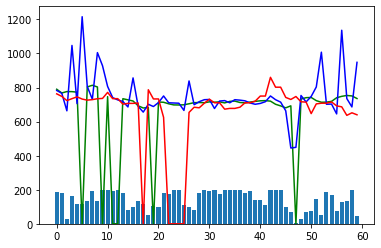

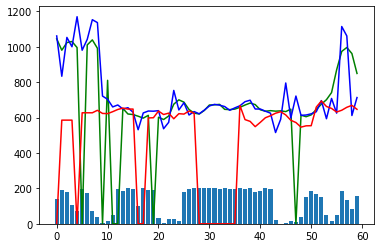

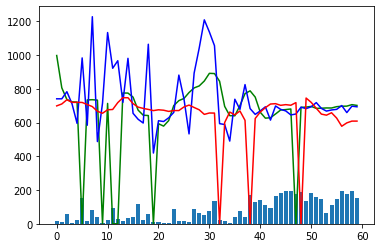

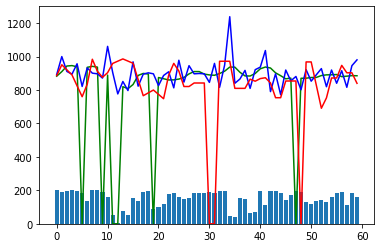

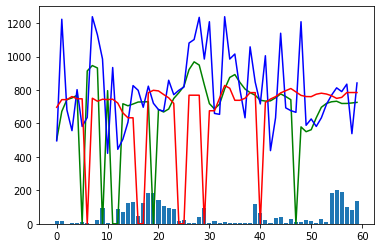

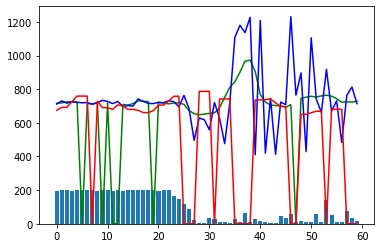

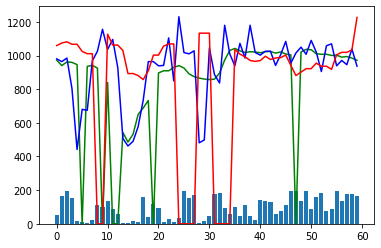

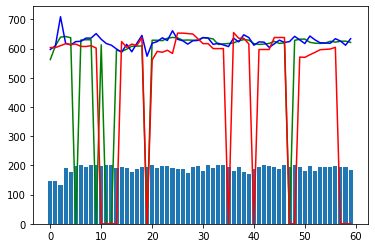

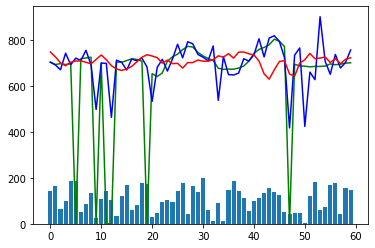

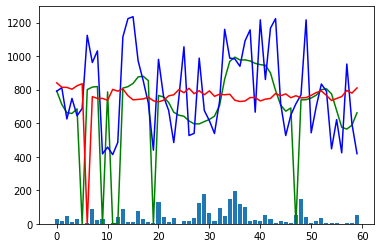

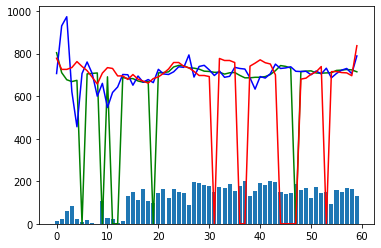

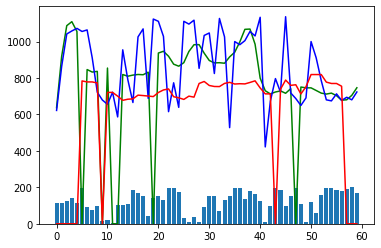

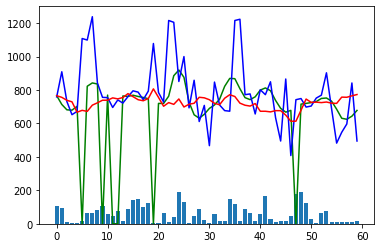

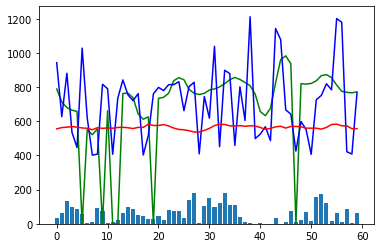

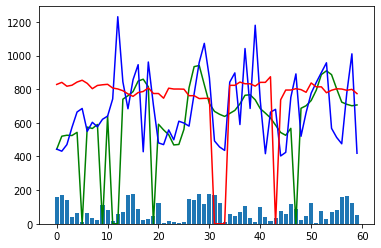

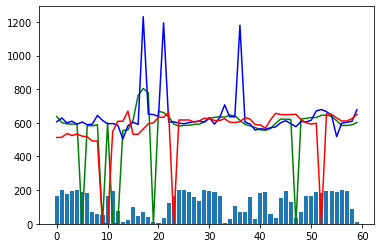

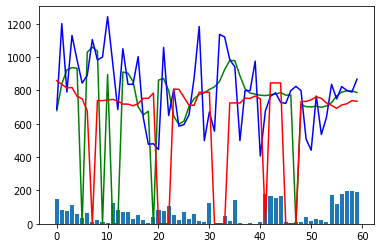

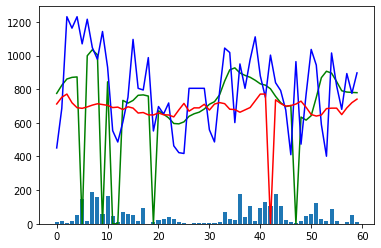

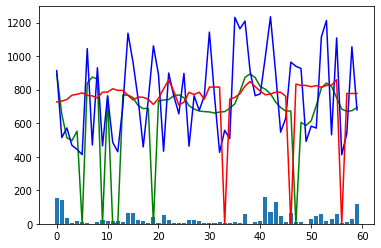

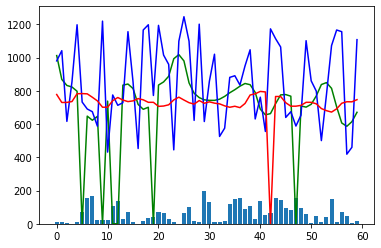

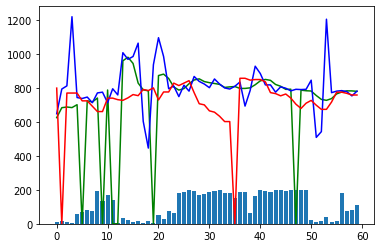

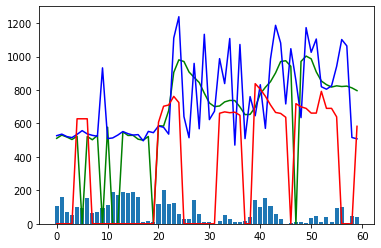

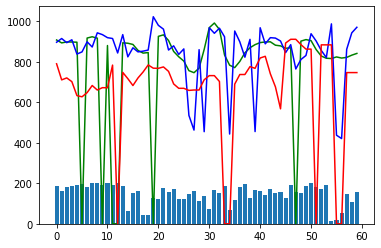

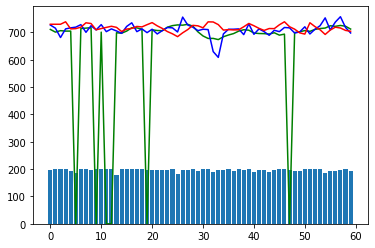

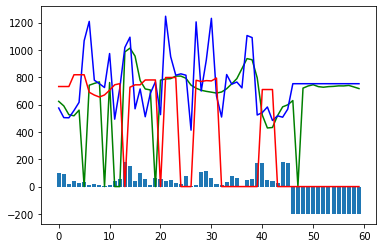

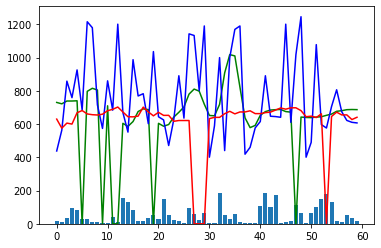

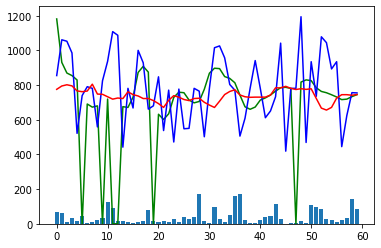

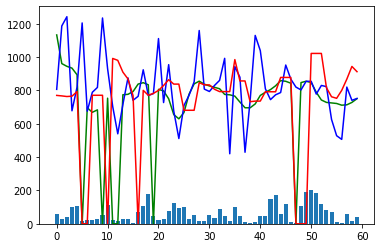

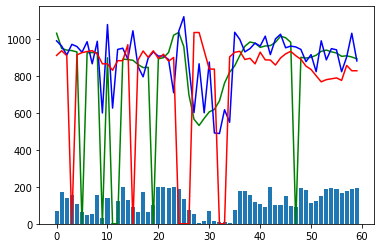

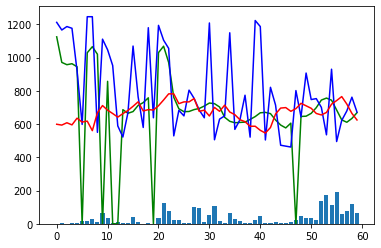

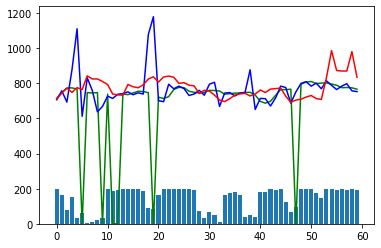

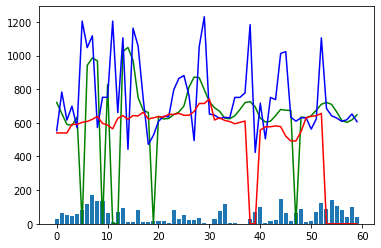

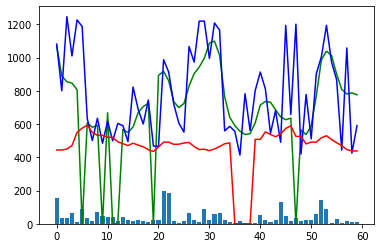

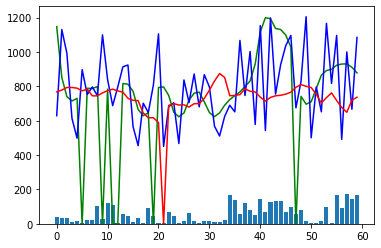

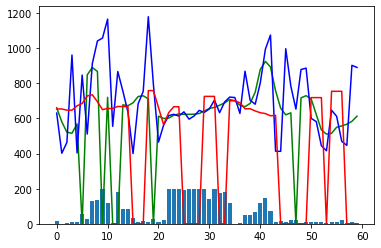

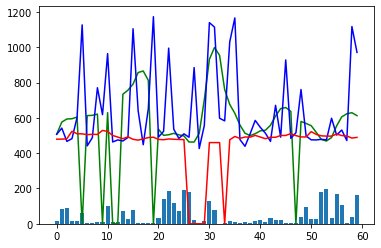

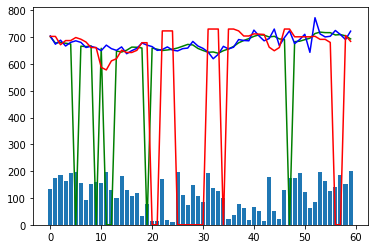

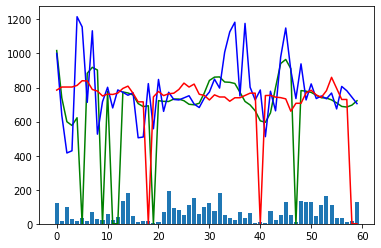

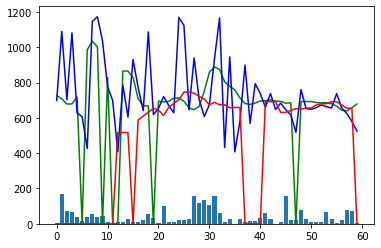

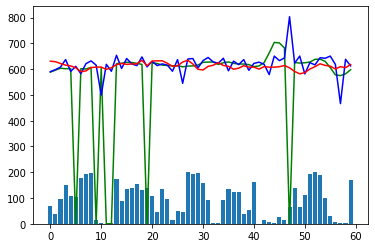

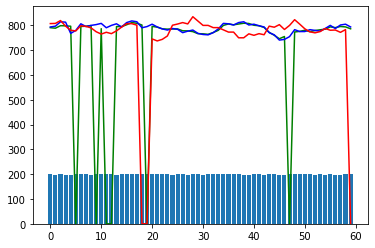

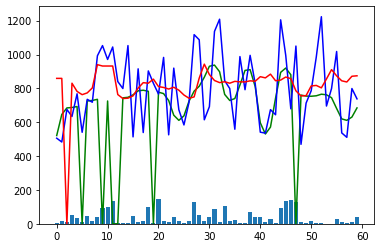

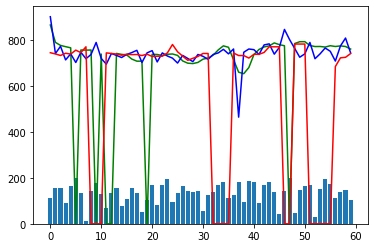

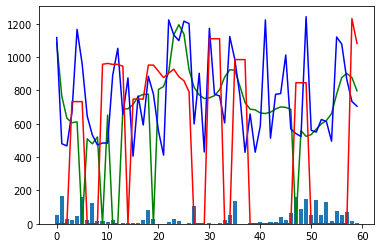

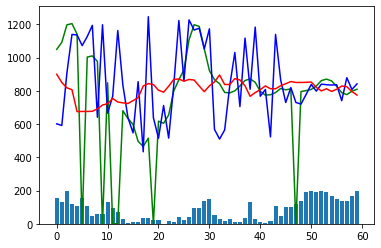

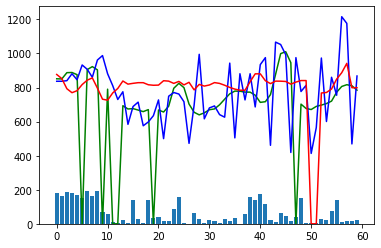

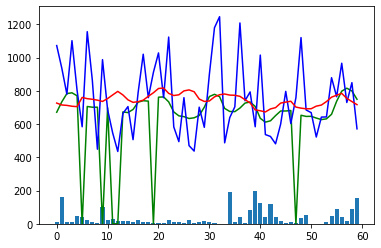

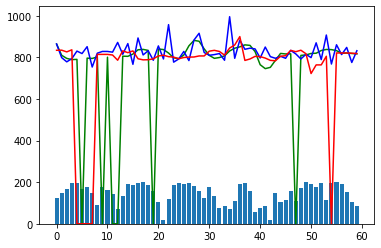

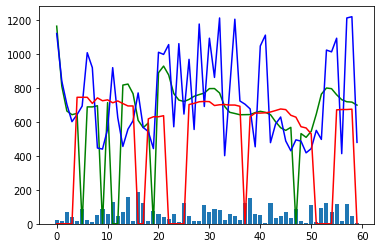

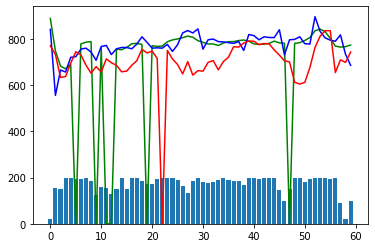

In [166]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:50]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#     plt.plot(X_test[i,:,:4],'r')
    plt.plot(y_test[i],'b')
#     plt.bar(range(60),y_test[i]*400,.9)
#     plt.bar(range(60),quals_test[i]*400,.45)
    plt.plot(ecg_test[i],'r')
    plt.bar(range(60),quals_test[i]*200)
    plt.show()

In [167]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [168]:
X = X[X[:,0]>=0]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
X = X[X[:,1]>0]

In [169]:
# plt.hist(X[:,0])
# y_test = y_test[:,:,0]
X[:,0] = X[:,0]

(227066, 4) 0.0
(164588, 4) 0.05
(98431, 4) 0.1
(67214, 4) 0.15000000000000002
(54986, 4) 0.2
(48648, 4) 0.25
(45637, 4) 0.30000000000000004
(42886, 4) 0.35000000000000003
(42019, 4) 0.4
(40375, 4) 0.45
(38505, 4) 0.5
(38248, 4) 0.55
(39281, 4) 0.6000000000000001
(40116, 4) 0.65
(40272, 4) 0.7000000000000001
(42494, 4) 0.75
(45945, 4) 0.8
(48423, 4) 0.8500000000000001
(61363, 4) 0.9
(131341, 4) 0.9500000000000001
20 20


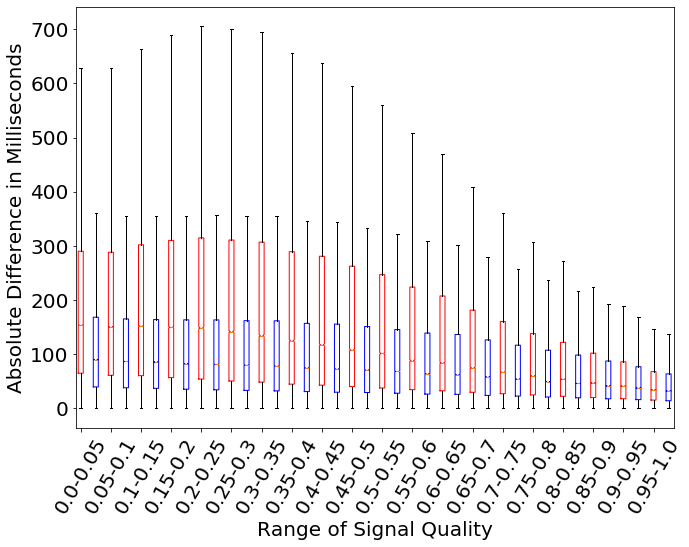

In [170]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [171]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    index = np.where(qual_min>=0)[0]
#     print(len(np.where(qual_min==-1)[0]))
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    ecg_min= ecg_min[~np.isinf(ecg_min)]
    
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_pred_min = y_pred_min[~np.isinf(y_pred_min)]
    
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[index] 
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    y_test_min = y_test_min[~np.isinf(y_test_min)]
    if len(ecg_min)<5 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
    q.append(len(np.where(qual_min>.5)[0])/60)

In [172]:
preds,ecgs,fpreds,q = np.array(x),np.array(y),np.array(z),np.array(q)

In [173]:
preds.shape,ecgs.shape,fpreds.shape,q.shape

((29686, 16), (29686, 16), (29686, 16), (29686,))

In [174]:
preds[:,-4]

array([inf, inf, inf, ..., inf, inf, inf])

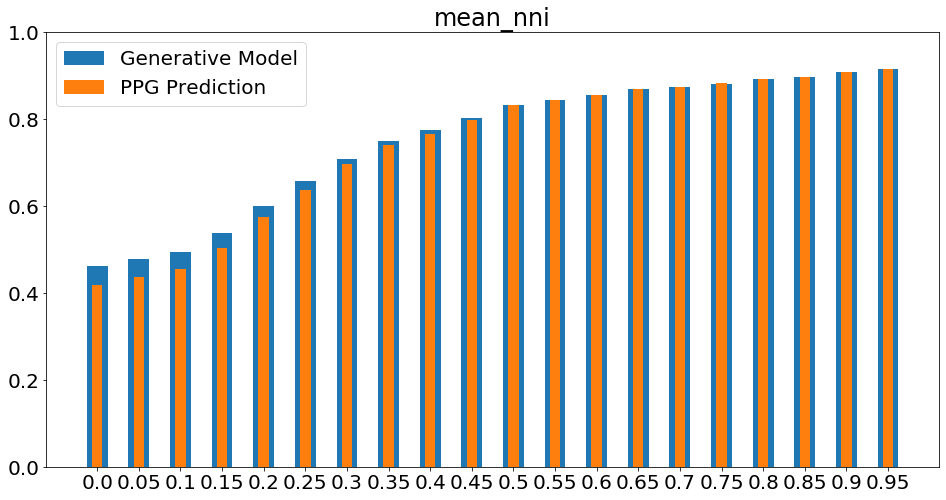

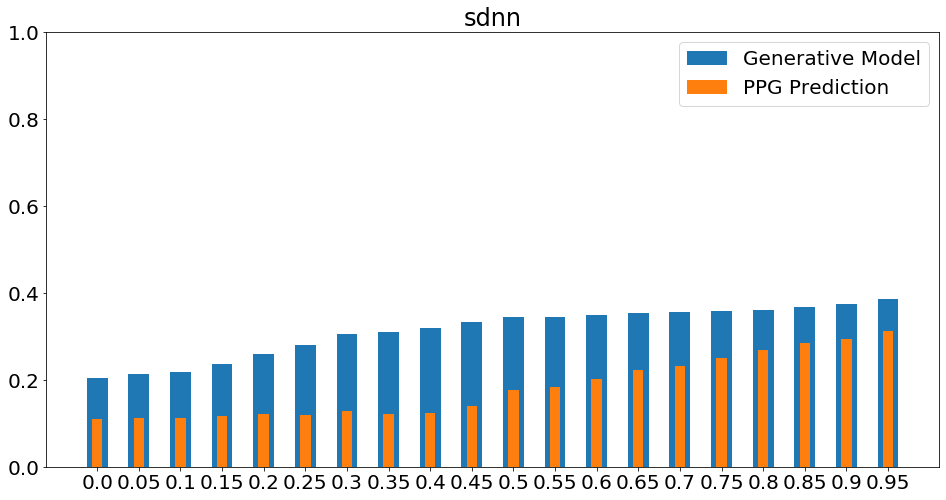

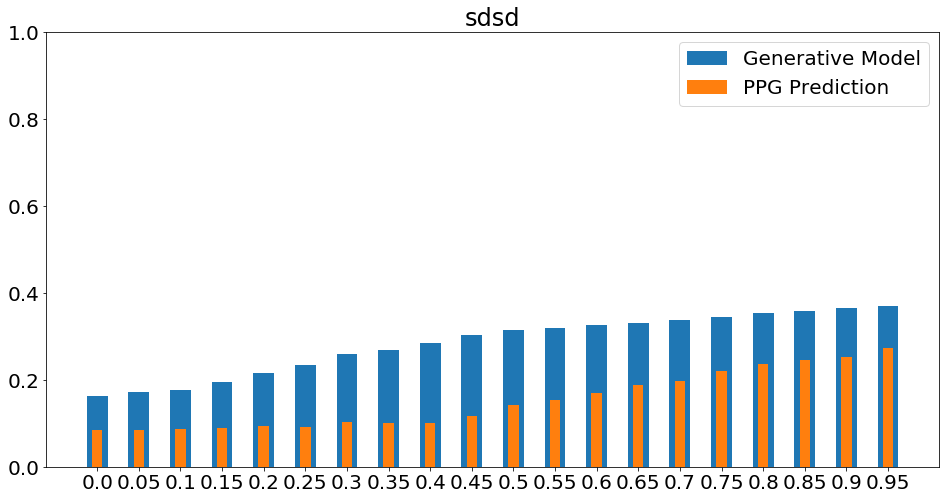

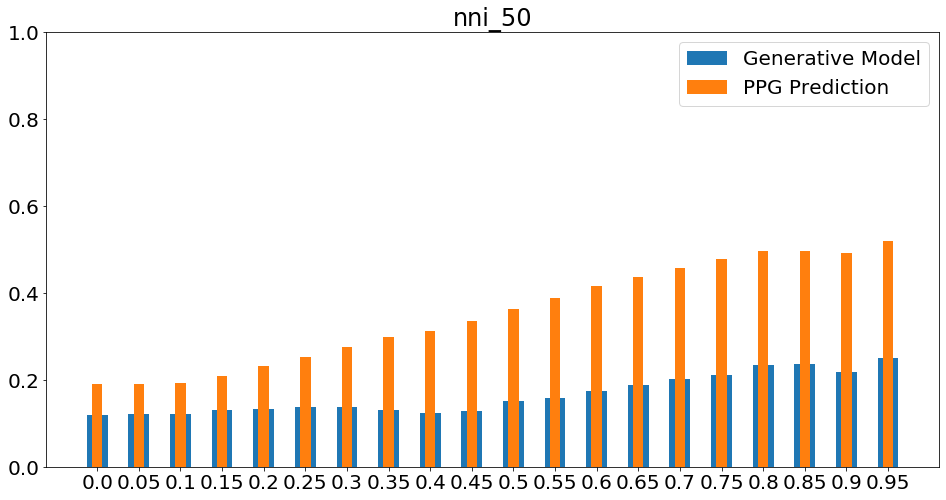

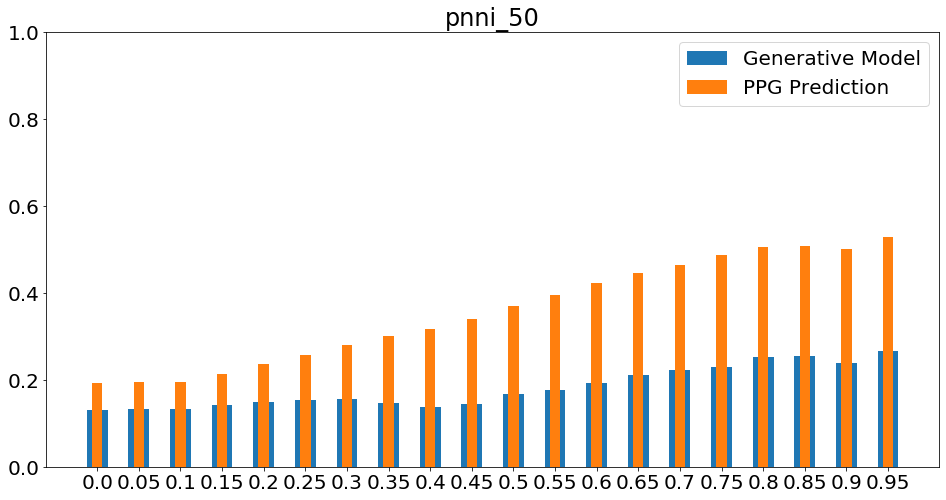

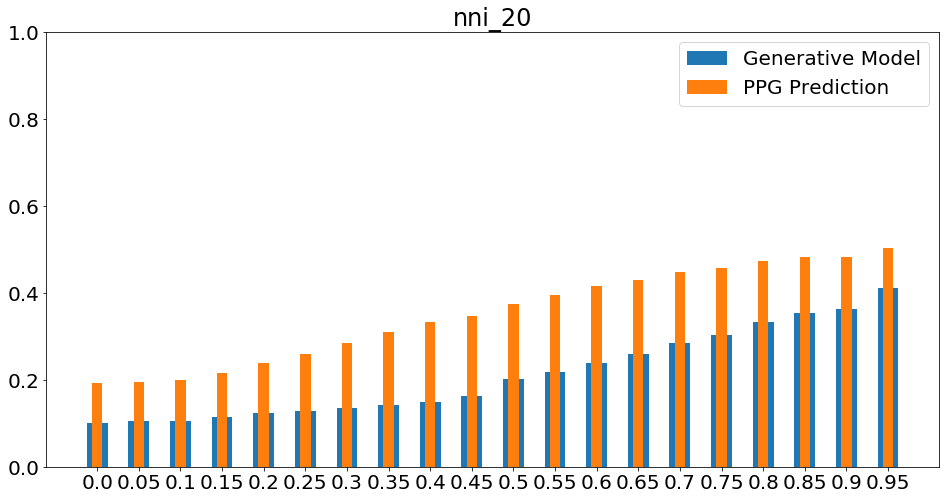

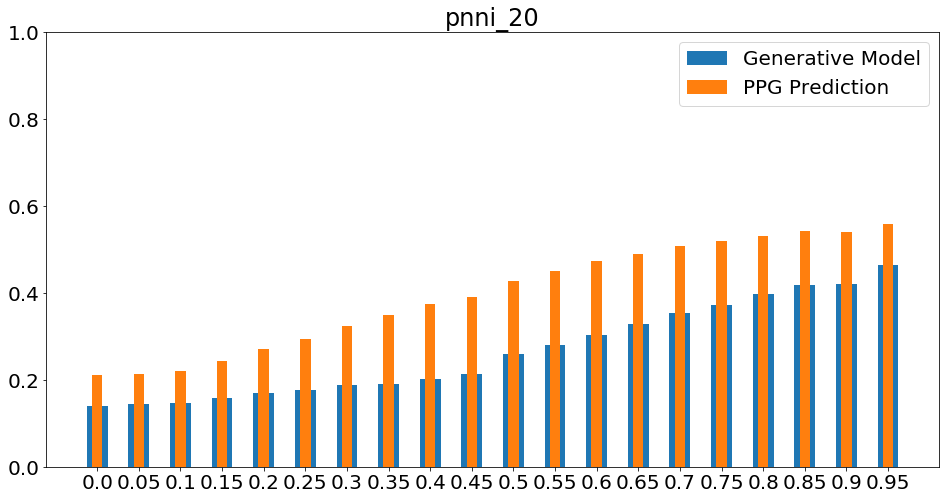

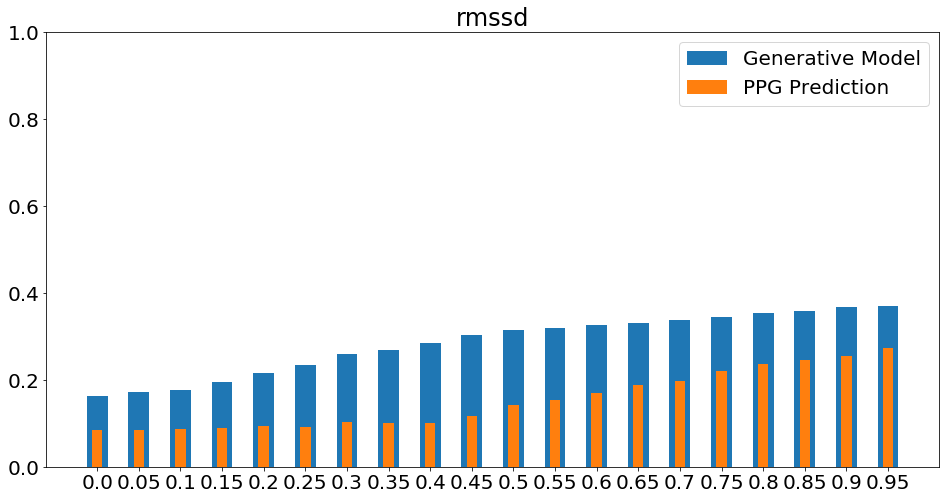

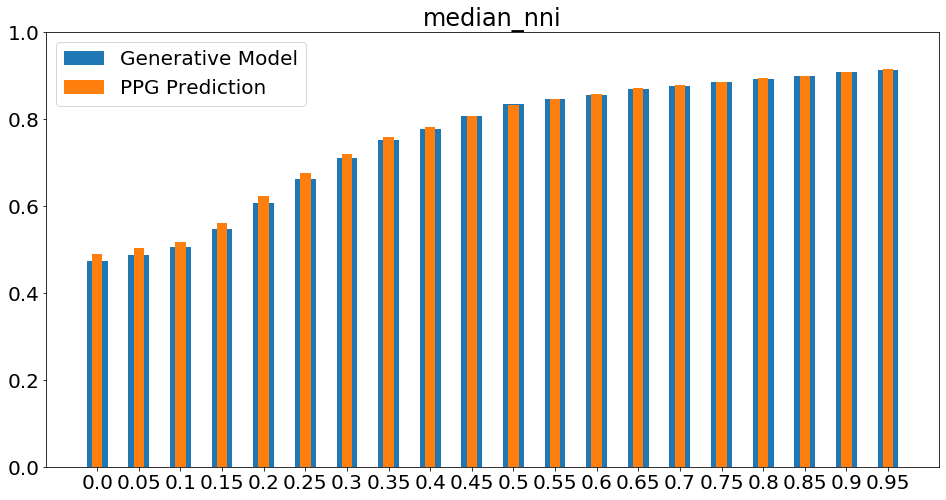

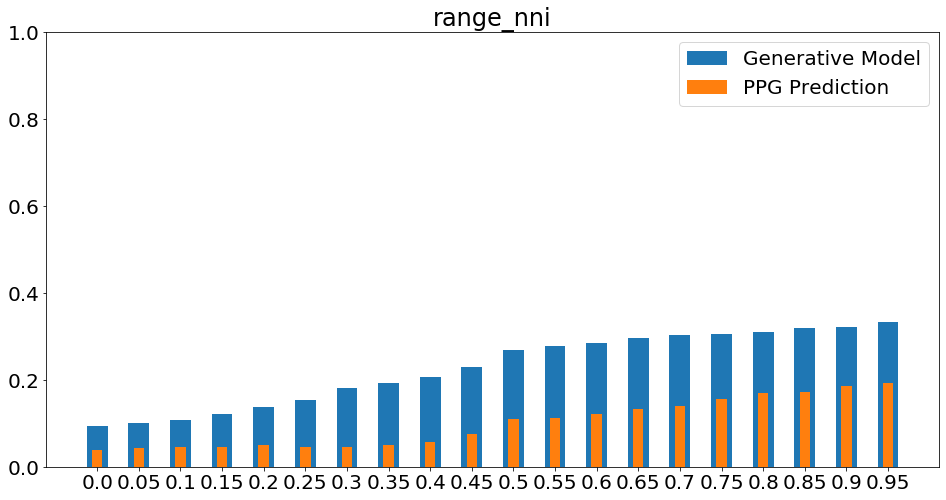

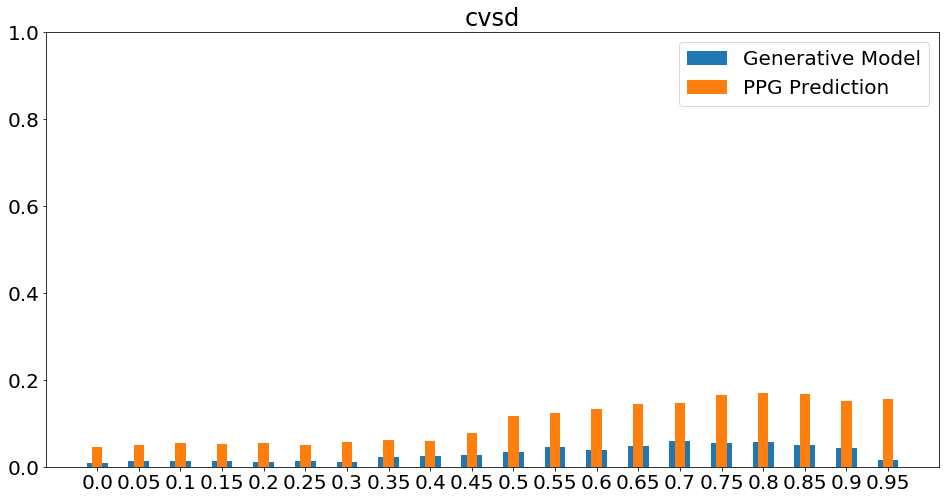

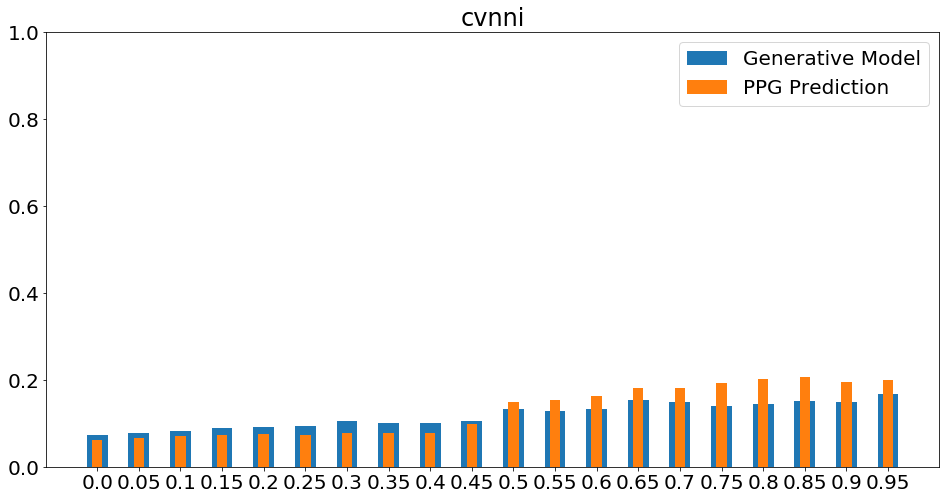

In [175]:
from scipy.stats import pearsonr
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni']

def get_pearson(x,y):
    index = ~np.isnan(x)
    x,y = x[index],y[index]
    index = ~np.isnan(y)
    x,y = x[index],y[index]
    return pearsonr(x,y)[0]

for j in range(len(feature_col)):
    x = []
    y = []
    y1 = []
    for i in np.linspace(0,.95,20):
        index = np.where((q>=i)&(q<=i+.5))[0]
#         print(len(index))
        if len(index)<10:
            continue
        x.append(str(np.round(100*i)/100))
#         print(pearsonr(ecgs[index,j],preds[index,j])[0])
        try:
            y.append(get_pearson(ecgs[index,j],preds[index,j]))
            y1.append(get_pearson(ecgs[index,j],fpreds[index,j]))
        except:
            continue
    try:
        plt.figure(figsize=(16,8))
        plt.bar(x,y,.5,label='Generative Model')
        plt.bar(x,y1,.25,label='PPG Prediction')
        plt.title(feature_col[j])
        plt.ylim([0,1])
        plt.legend()
#         plt.xticks(rotation=60)
        plt.show()
    except Exception as e:
        continue

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability